In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib
from scipy.optimize import curve_fit
from scipy.signal import find_peaks,savgol_filter
from scipy.stats import linregress
from scipy.constants import Boltzmann,c as light,u
import json
matplotlib.rc('axes.formatter', useoffset=False)
# %matplotlib atagg
# matplotlib.use('Qt5Agg')
plt.rcParams.update({'font.size': 10})

In [3]:
with open('kali.txt') as json_file:
    kali = json.load(json_file)
print(kali)
def lin_func(x,slope,intercept):
    return slope*x+intercept

{'0': [-0.0006831583189536933, 780.247753204327], '3': [-0.0006593473937488854, 780.247552537188], '4': [-0.0006557151961520067, 780.2473265396443], '5': [-0.0006487626584672954, 780.2472880580533], '6': [-0.0006303134830736428, 780.2472357235326]}


In [4]:
class Spek():
    def __init__(self,freq,cut=False):
        self.freq=freq
        path=f"data/doppler/{freq}freq.dat"
        self.time, self.U_piezo, self.U_fp, self.U_spek, self.intensity = np.genfromtxt(path).T
        # Piezo-Spannung muss noch mit vier multipliziert werden.
        self.U_piezo = 4 * self.U_piezo

        # Falls cut == True, werden die Daten auf eine steigende Flanke der Piezo-Spannung zugeschnitten.
        if cut:
            # Finden des Minimums und Maximums
            # Bei mehreren Minima und Maxima ist die hardgecodete Auswahl über den letzten Index echt unschön...
            min = find_peaks(-1.0*self.U_piezo,width=2000)[0][0]
            max = find_peaks(self.U_piezo,width=2000)[0][-1]

            self.time = self.time[min:max+1]
            self.U_piezo = self.U_piezo[min:max+1]
            self.U_fp = self.U_fp[min:max+1]
            self.U_spek = self.U_spek[min:max+1]
            self.intensity = self.intensity[min:max+1]
        self.time=self.time-self.time[0]
        self.lamb=lin_func(self.U_piezo,kali[str(freq)][0],kali[str(freq)][1])
        self.omega=2*np.pi*light/(self.lamb*1e-9)

    def func_gauss(self,nu,A,nu0,sigma):
        return A*np.exp(-(nu-nu0)**2/(2*sigma**2))
    def peaks(self):
        # self.popt1,self.pcov1=curve_fit(self.func_gauss,self.omega[6800:7700],self.diff[6800:7700],p0=[0.3,780.238,0.0001])
        # self.popt2,self.pcov2=curve_fit(self.func_gauss,self.omega[4700:5600],self.diff[4700:5600],p0=[0.3,780.244,0.0001])
        # self.popt3,self.pcov3=curve_fit(self.func_gauss,self.omega[3600:4700],self.diff[3600:4700],p0=[0.3,780.24,0.0001])
        self.popt1,self.pcov1=curve_fit(self.func_gauss,self.omega[6800:7700],self.diff[6800:7700],p0=[0.18,2.414182e15,6e8],maxfev=10000)
        self.popt2,self.pcov2=curve_fit(self.func_gauss,self.omega[4700:5600],self.diff[4700:5600],p0=[0.2,2.414199e15,6e8],maxfev=10000)
        self.popt3,self.pcov3=curve_fit(self.func_gauss,self.omega[3600:4700],self.diff[3600:4700],p0=[0.2,780.24,10])
    def plot(self,title=None):
        fig = plt.figure(figsize=(7, 5))
        gs = GridSpec(8, 5)
        fig1 = fig.add_subplot(gs[:, :])
        # fig1.set_title(f"Laser")
        fig1.set_ylabel(r'$U_\mathrm{Spektrum}$ in V')
        fig1.set_xlabel("t in s")
        # fig1.set_xlim(-5,185)
        # fig1.set_ylim(0,9.5)
        plt.tight_layout()
        plt.plot(self.time,self.U_spek,c="C0",label="ohne Blende")
        plt.legend()
        # plt.savefig("figures/dopplerfrei_both.pdf")
        plt.show()
    # def plot_diff(self,title=None):
    #     fig = plt.figure(figsize=(7, 5))
    #     gs = GridSpec(8, 5)
    #     fig1 = fig.add_subplot(gs[:, :])
    #     # fig1.set_title(f"Laser")
    #     fig1.set_ylabel(r'$U_\mathrm{Diff}$ in V')
    #     fig1.set_xlabel("$\lambda$ in nm")
    #     lim=0
    #     if lim==1:
    #         fig1.set_xlim(780.238,780.2395)
    #         fig1.set_xticks([780.238,780.2385,780.239,780.2395])
    #     if lim==2:
    #         fig1.set_xlim(780.243,780.245)
    #         fig1.set_xticks(np.arange(780.243,780.24501,0.0005))
    #     if lim==3:
    #         fig1.set_xlim(780.245,780.248)
    #         fig1.set_xticks(np.arange(780.245,780.24801,0.0005))
    #     # fig1.set_ylim(0,9.5)
    #     plt.tight_layout()
    #     # plt.plot(self.lamb,self.func_gauss(self.lamb,self.popt2[0],self.popt2[1],self.popt2[2]),c="C2")
    #     # plt.plot(self.lamb,self.func_gauss(self.lamb,self.popt1[0],self.popt1[1],self.popt1[2]),c="C2")
    #     plt.plot(self.omega,self.func_gauss(self.omega,self.popt2[0],self.popt2[1],self.popt2[2]),c="C2")
    #     plt.plot(self.omega,self.func_gauss(self.omega,self.popt1[0],self.popt1[1],self.popt1[2]),c="C2")
    #     # fig1.scatter(self.lamb[self.peaks_i],self.diff[self.peaks_i],c="C1",label="Peaks")
    #     fig1.plot(self.omega,self.diff,c="C0",label="Spektrum")
    #     fig1.set_title(f"Frequenz {self.freq}")
    #     plt.legend()
    #     plt.tight_layout()
    #     # plt.savefig(f"figures/diff_freq{self.freq}.png")
    #     plt.show()

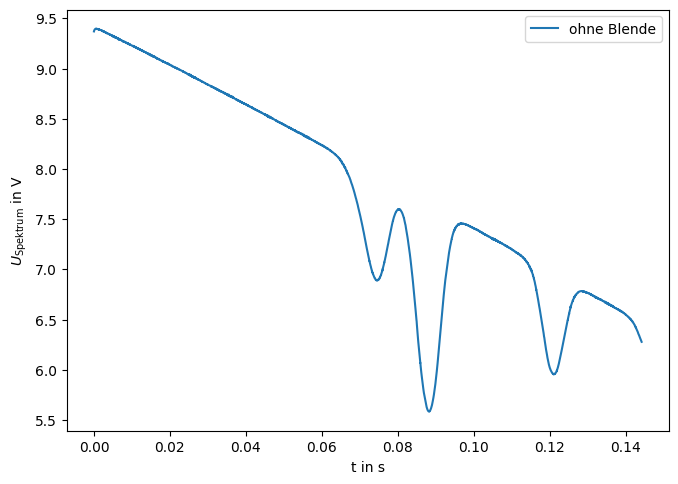

In [7]:
spek6=Spek(6,cut=True)
spek6.plot()